<a href="https://colab.research.google.com/github/axel-sirota/nlp-and-transformers/blob/main/module3/NLPTransformers_Mod3Demo2_SelfAttention_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducing self attention

© Data Trainers LLC. GPL v 3.0.

Author: Axel Sirota

In order to get closer to the Transformer we will neeed to understand Se;f Attention. this concept simply relates attention with a database. In a database you have a key value pair, and with a query you get a key and with that key you return the value, right?

In self-attention ( or sometimes called  Q, K, V attention) we do the same, but instead of getting one key we will get:

$$a_{i, k} = similarity(Q_i, K_k)$$

Therefore

$$ c_i = ∑_{k}a_{i,k}*v_k $$

Which basically means we get a weighted average of **ALL** the values for every input word we want to calculate the alignment. Therefore the term self attention. The diference with the previous attention is that before the similarity function was the dot product, and the matrices `K,Q,V` where the identity (only ones in the diagonal) and here they are learneable!

## Prep

In [1]:
import os
nltk_data_path = os.path.join(os.path.dirname(os.path.abspath('./')), 'NLTK')
os.environ['NLTK_DATA'] = nltk_data_path

import nltk
nltk.data.path = [nltk_data_path]

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import gensim
from nltk.data import find

nltk.download("word2vec_sample")

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /home/freak/Freak/Trainings/AI-ML/NLTK...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [10]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x))

In [11]:
def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(np.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = np.array(output)
    del model  # free up space again
    return embeddings, words_pass


In [12]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

In [13]:
def embed_sentence(sentence):
    # Embed a sentence using word2vec; for example use cases only.
    sentence = re.sub(r"[^\w\s]", "", sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return np.expand_dims(word_vector_sequence, axis=0), words

## Seeing the attention

In order to see self attention, we just need to do what we did before! But now we will use a variant called **Scaled self attention** which is the one Transformers almost use:

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

It is *very* important to remark all of this later will be done  by the Tensorflow or PyTorch!

In [14]:
def scaled_dot_product_attention(query, key, value):
    d_k = key.shape[-1]
    logits = np.matmul(query, np.swapaxes(key, -2, -1))
    scaled_logits = logits / np.sqrt(d_k)
    attention_weights = softmax(scaled_logits, axis=-1)
    value = np.matmul(attention_weights, value)
    return value, attention_weights

## Testing it out!

In [15]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape

/tmp/ipykernel_193508/665568944.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


(1, 6, 300)

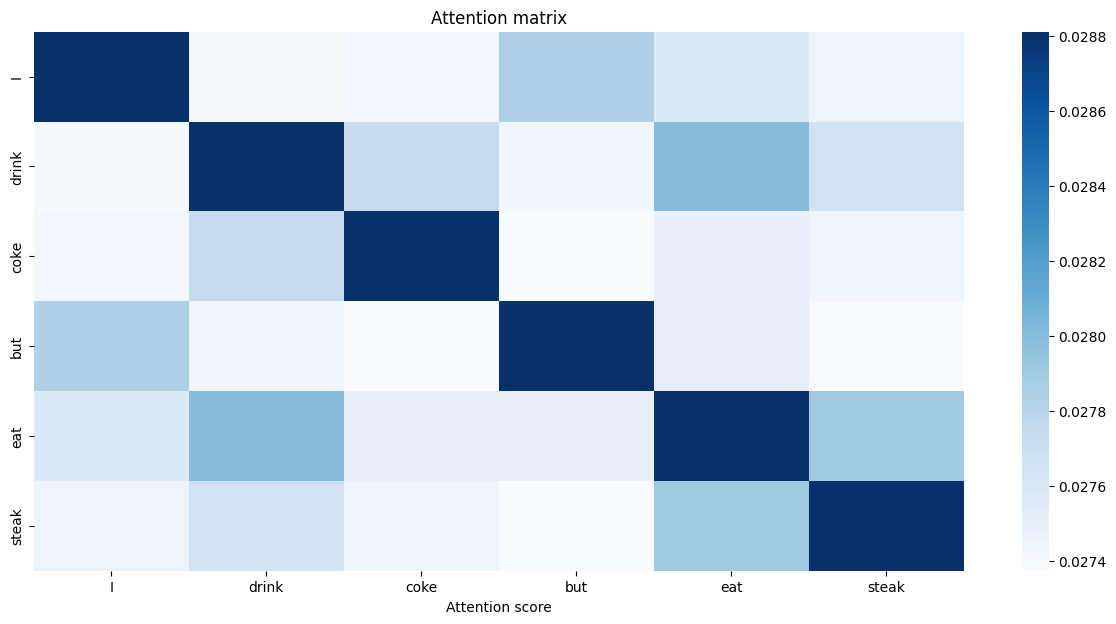

In [16]:
Q = K = V = word_embeddings   # Para no entrenar

# calculate weights and plot
values, attention_weights = scaled_dot_product_attention(Q, K, V)
words = re.sub(r"[^\w\s]", "", sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)

In effect you can see a positive alignment between drink and coke, as well as eat and steak.